In [119]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
Root = 'C:/FishIsland_2017/'


FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Met_Path = Root+'MetStationData/CR1000_ClimateData_Updated.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'



In [ ]:
class Compile:
    def __init__(self,Flux_Paths,Met,Soil):
        Flux_10 = self.Format(pd.read_csv(Flux_Paths[0],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
        Flux_1 = self.Format(pd.read_csv(Flux_Paths[1],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
#         Flux_10.fillna(Flux_Fill)
        Flux_10['Hz']=10
        Flux_1['Hz'] = 1
        Flux = Flux_1.append(Flux_10)
        Met = self.Format(pd.read_csv(Met,delimiter = ',',skiprows = 1,parse_dates={'datetime':[0]},header = 0),v=2,drop = [0])
        Soil = self.Format(pd.read_csv(Soil,delimiter = ',',skiprows = 0,parse_dates={'datetime':[0]},header = 0),v=0,drop = [0])

        self.RawData = pd.concat([Flux,Met,Soil],axis = 1, join = 'outer')
        
        self.RawData['Minute'] = self.RawData.index.hour*60+self.RawData.index.minute
        self.Wind_Bins(30)
        self.PPFD_Bins(100)
        self.RawData['Day'] = np.floor(self.RawData['DOY'])
        
        eastern = pytz.timezone('US/Mountain')
        self.RawData['UTC'] = self.RawData.index.tz_localize(pytz.utc).tz_convert(eastern)

    def Format(self,df,v,drop):
        df = df.ix[v:]
        df = df.set_index(pd.DatetimeIndex(df.datetime))
        df = df.drop(df.columns[drop],axis=1)
        df = df.astype(float)
        return(df)
    
    def Date_Drop(self,Date):
        self.RawData = self.RawData.drop(self.RawData.loc[(self.RawData.index>Date[0])&(self.RawData.index<Date[1])].index)

    def Wind_Bins(self,Bins):
        self.bins = np.arange(0,360.1,Bins)
        self.RawData['Dir'] = pd.cut(self.RawData['wind_dir'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)

    def PPFD_Bins(self,Bins):
        self.bins = np.arange(0,self.RawData['PPFD_Avg'].max()+1,Bins)
        self.RawData['Photon_Flux'] = pd.cut(self.RawData['PPFD_Avg'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)

    def Ustar_thresh_calc(self):
        self.RawData['TempClass'] = np.nan
        self.RawData['uClass'] = np.nan
        self.RawData['uClass_Val'] = np.nan
        self.RawData['ClassID'] = np.nan
        self.RawData['ClassMean'] = np.nan
        Data = self.RawData[self.RawData['PPFD_Avg']<100]
        Q = Data.quantile(np.arange(1,7,1)/6)['AirTC_Avg'].values
        Q = np.insert(Q,0,Data['AirTC_Avg'].min())
        for i,q in enumerate(Q):
            Data.loc[Data['AirTC_Avg']>q,'TempClass']=i#+1
        for i,q in enumerate(Q):
            qi = 0
            Q2 = Data.loc[Data['TempClass']==i].quantile(np.arange(1,21,1)/20)['u*'].values
            Q2 = np.insert(Q2,0,Data['u*'][Data['TempClass']==i].min())
            for i2,q2 in enumerate(Q2[:-1]):
                Data.loc[((Data['u*']>q2)&(Data['TempClass']==i)),'uClass']=i2
                Data.loc[((Data['u*']>q2)&(Data['TempClass']==i)),'uClass_Val']=(Q2[i2+1]+q2)/2
                Data.loc[((Data['u*']>q2)&(Data['TempClass']==i)),'ClassID']=i2+i*100
                Data.loc[((Data['u*']>q2)&(Data['TempClass']==i)),'ClassMean'] = \
                    Data['co2_flux'][((Data['u*']>=q2)&(Data['TempClass']==i))].mean()
                qi = q2
        self.RawData[self.RawData['PPFD_Avg']<100] = Data
        plt.plot(self.RawData['uClass_Val'])
                


        
    def Process(self,qc_thresh=None,rain_thresh=None,ch4_signal_thresh=None,spike_thresh=None,wind_drop=None,U_thresh=None):
        self.Fluxes = ['H','LE','co2_flux','ch4_flux']
        self.Data = self.RawData.copy()
#         self.Date_Drop('2017-06-23 15:00:00')
        if qc_thresh!=None:
            self.QC_Check(qc_thresh)
        if wind_drop!=None:
            self.Wind_Filter(wind_drop)
        if U_thresh!=None:
            self.Ustar_Check(U_thresh)
        if rain_thresh!=None:
            self.Rain_Check(rain_thresh)
        if ch4_signal_thresh!=None:
            self.Signal_Check(ch4_signal_thresh)
        if spike_thresh!=None:
            self.Spike_Removal(spike_thresh)
        self.NAN_Check()
    
    def QC_Check(self,thresh):
        for var in self.Fluxes:
            self.Data[var+'_drop'] = 0
            self.Data.loc[self.Data['qc_'+var]>=thresh,[var,var+'_drop']]=[np.nan,1]
            
    def Wind_Filter(self,width):
        for var in self.Fluxes:
            self.Data.loc[((self.Data['wind_dir']>215-width)&(self.Data['wind_dir']<215+width)),[var,var+'_drop']]=[np.nan,1]
        
        
    def Ustar_Check(self,U_thresh):
        for var in self.Fluxes:
            self.Data.loc[self.Data['u*']<U_thresh,[var,var+'_drop']]=[np.nan,1]
        
    def Rain_Check(self,thresh):
        self.Data['Rain_diff'] = self.Data['Rain_mm_Tot'].diff()
        for var in self.Fluxes:
            if var!='ch4_flux':
                self.Data.loc[self.Data['Rain_mm_Tot']>thresh[0],[var,var+'_drop']]=[np.nan,1]
            else:
                self.Data.loc[self.Data['Rain_mm_Tot']>thresh[1],[var,var+'_drop']]=[np.nan,1]
#            self.Data.loc[self.Data['Rain_diff']<thresh,[var,var+'_drop']]=[np.nan,1]
            
    def Signal_Check(self,thresh):
        self.Data['ch4_noSSFilter'] = self.Data['ch4_flux']
        self.Data.loc[self.Data['rssi_77_mean']<thresh,['ch4_flux','ch4_flux_drop']] = [np.nan,1]
                              
    def Spike_Removal(self,z_thresh,AltData=None):
        if AltData == None:
            for var in self.Fluxes:
                series = self.Data[var].dropna()
                di1 = series.diff()
                di1[:-1] = di1[1:]
                di = di1.diff()
                MD = di.median()
                MAD = np.abs(di-MD).median()
                F1 = di<MD-(z_thresh*MAD/0.6745)
                F2 = di>MD+(z_thresh*MAD/0.6745)
                series.loc[F1==True]=np.nan
                series.loc[F2==True]=np.nan
                Droppers = series.index[np.isnan(series)==True]
                VAR = self.Data[var]
                VAR.ix[Droppers] = np.nan
                dina = VAR.diff()
                dina[:-1] = dina[1:]
                dina2 = VAR.diff()
                NaMid = VAR.index[((np.isnan(dina)==True)&(np.isnan(dina2)==True))]
                VAR.ix[NaMid] = np.nan
                self.Data[var] = VAR
        else:
            series = AltData[0][AltData[1]].dropna()
            di1 = series.diff()
            di1[:-1] = di1[1:]
            di = di1.diff()
            MD = di.median()
            MAD = np.abs(di-MD).median()
            F1 = di<MD-(z_thresh*MAD/0.6745)
            F2 = di>MD+(z_thresh*MAD/0.6745)
            series.loc[F1==True]=np.nan
            series.loc[F2==True]=np.nan
            Droppers = series.index[np.isnan(series)==True]
            VAR = self.Data[var]
            VAR.ix[Droppers] = np.nan
            dina = VAR.diff()
            dina[:-1] = dina[1:]
            dina2 = VAR.diff()
            NaMid = VAR.index[((np.isnan(dina)==True)&(np.isnan(dina2)==True))]
            VAR.ix[NaMid] = np.nan
            AltData[0][AltData[1]] = VAR
            return(AltData[0])
                
                     
    def NAN_Check(self):
        for var in self.Fluxes:
            self.Data.loc[np.isnan(self.Data[var]) == True,[var+'_drop']]=1

## Initialize everything and parse the data
Comp = Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path)

In [ ]:
## Remove unwanted Data
Comp.Date_Drop(['2017-06-01 15:00:00','2017-06-23 15:00:00'])

## Determine u* threshold
Comp.Ustar_thresh_calc()

In [ ]:

plt.figure(figsize=(10,10))
for t in range(0,6,1):
    Cl = []
    Vr = []
    for u in range(1,20,1):
        i1 = t*100+u
        i2 = t*100+u-1
        m1 = Comp.RawData['ClassMean'][Comp.RawData['ClassID']==i1].mean()
        m2 = Comp.RawData['ClassMean'][Comp.RawData['ClassID']==i2].mean()
        Cl.append(Comp.RawData['uClass_Val'][Comp.RawData['ClassID']==i1].mean())
        Vr.append(m1/m2)
#         print(m1,m2)
#         print(Comp.RawData['uClass'][Comp.RawData['ClassID']==i1].mean())
    #         print(t,u)
    Cl = np.asanyarray(Cl)
    Vr = np.asanyarray(Vr)
#     print(Cl,Vr)
#     plt.plot(Cl,Vr)
# plt.ylim(0,1.25)
# plt.grid()

plt.figure(figsize=(10,10))
plt.scatter(Comp.RawData['uClass_Val'],Comp.RawData['ClassMean'])

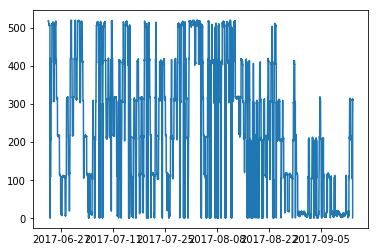

In [399]:
from scipy.optimize import curve_fit

# def Sigmoid(x,a,b):
#     return(a*((1+np.exp(-x)))+b)


# def SquareRoot(x,a,b,c):
#     return(a*x**b+c)

Data = Comp.RawData
Q = Data.quantile(np.arange(1,7,1)/6)['AirTC_Avg']
# print(Q)
Data['TempClass'] = 1
Data['uClass'] = 1
for i,q in enumerate(Q.values[0:-1]):
    Data.loc[Data['AirTC_Avg']>=q,'TempClass']=i+2
for i,q in enumerate(Q.values):
    Q2 = Data.loc[Data['TempClass']==i+1].quantile(np.arange(1,21,1)/20)['u*']
    for i2,q2 in enumerate(Q2.values[:-1]):
        Data.loc[((Data['u*']>=q2)&(Data['TempClass']==i+1)),'uClass']=i2+2+i*100

    
# print(Q)
    
#     print(Data.loc[Data['AirTC_Avg']<=q][['AirTC_Avg','TempClass']].head(5))
#     print()
# print(Data['AirTC_Avg'])
plt.plot(Data['uClass'])
# Data=Comp.RawData[['u*','ch4_flux']].dropna()

# popt, pcov = curve_fit(SquareRoot, Data['u*'].values, Data['ch4_flux'].values)

# print(popt,pcov)

# # plt.figure(figsize=(10,10))
# # plt.plot(Comp.RawData['co2_flux'].resample('D').mean()*3.6,linewidth=10,color='red')
# # plt.plot(Comp.Data['co2_flux'].resample('D').mean()*3.6,linewidth=4,color='green')


# plt.figure(figsize=(10,10))
# plt.scatter(Comp.RawData['u*'],Comp.RawData['ch4_flux'])
# plt.ylabel('CH4 Flux')
# plt.xlabel('u*')
# # plt.xlim(-.01,.4)

# Ten = np.arange(0,10,.01)

# # plt.plot(Ten,   popt[0]*(1/(1+np.exp(-Ten)))+popt[1]    )
# plt.plot(Ten,popt[0]*Ten**popt[1]+popt[2])

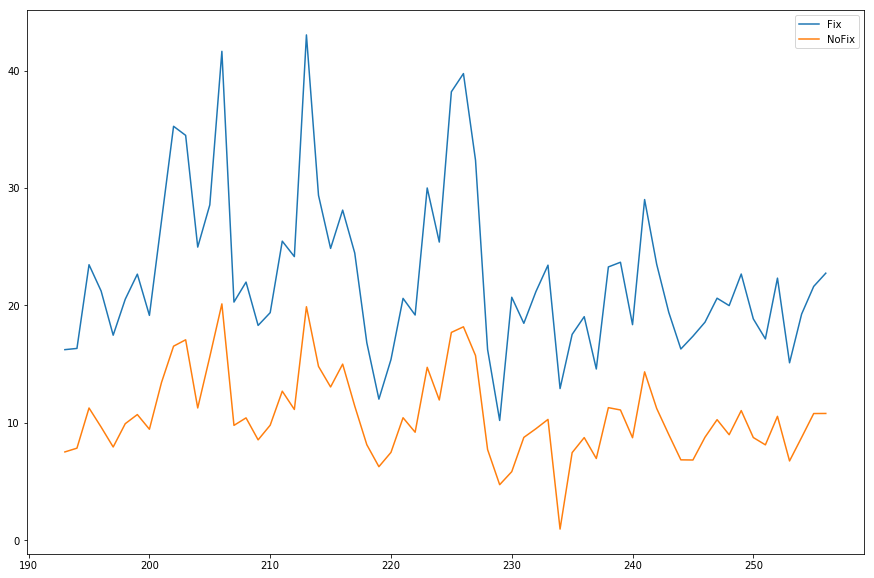

In [33]:
def Scatter(Var,xl=None,yl=None):
    plt.figure(figsize=(7,7))
    plt.scatter(Fix[Var],NoFix[Var])
    plt.xlabel('Fix')
    plt.ylabel('NoFix')
    if xl!=None:
        plt.xlim(xl[0],xl[1])
        plt.ylim(yl[0],yl[1])
    plt.title(Var)

# Scatter('Wind')
# # Scatter('u*')
# Scatter('co2_strg',[-2,2],[-2,2])
# Scatter('qc_co2_flux')#,[-5,5],[-5,5])

plt.figure(figsize=(15,10))
plt.legend()
# Scatter('H')
# Scatter('LE')


In [109]:
# plt.figure(figsize=(10,10))


for root,Dir,files in (os.walk(Root+'TagluStationData/Daily/')):
    for i,file in enumerate(files):
        print(files,i)
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,2,3])[0]
#         print(df.head())
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        if i == 0:
            Daily = df
        else:
            Daily = Daily.append(df)
#         df=df.resample('D').max()
#         plt.plot(Hourly.index.dayofyear,Hourly['WindSpd']*3.6,color=(0,0,0,.5))
#         plt.xlim(190,260)


for root,Dir,files in (os.walk(Root+'TagluStationData/Hourly/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,1,3])[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        if i == 0:
            Hourly = df
        else:
            Hourly = Hourly.append(df)
#         df=df.resample('D').mean()
#         plt.plot(df.index.dayofyear,df['WindSpd']*3.6,color=(0,0,0,.75))
#         plt.xlim(190,260)
     
    

# plt.plot(Fix['Wind'].resample('D').mean().index.dayofyear,Fix['Wind'].resample('D').mean(),label='Fix',
#         linewidth=4)
# plt.plot(NoFix['Wind'].resample('D').mean().index.dayofyear,NoFix['Wind'].resample('D').mean(),label='NoFix',
#         linewidth=4)

# plt.ylim(0,30)

# print(Daily.index.dayofyear)
Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>1] = np.nan
Daily['Snow_Depth'].ffill()

['Taglu Tower DAILY 2008 Aug 27_Dec 31.xls', 'Taglu Tower DAILY 2009 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2010 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2011 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2012 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2013 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2014 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2015 Jan 1_Dec 31.xlsx', 'Taglu Tower DAILY 2016 Jan 1_July.xlsx'] 0
['Taglu Tower DAILY 2008 Aug 27_Dec 31.xls', 'Taglu Tower DAILY 2009 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2010 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2011 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2012 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2013 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2014 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2015 Jan 1_Dec 31.xlsx', 'Taglu Tower DAILY 2016 Jan 1_July.xlsx'] 1
['Taglu Tower DAILY 2008 Aug 27_Dec 31.xls', 'Taglu Tower DAILY 2009 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2010 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2011 Jan 1_Dec 31.xls', 'Taglu Tower DAILY 2012 Jan 1_Dec 31.xls', '

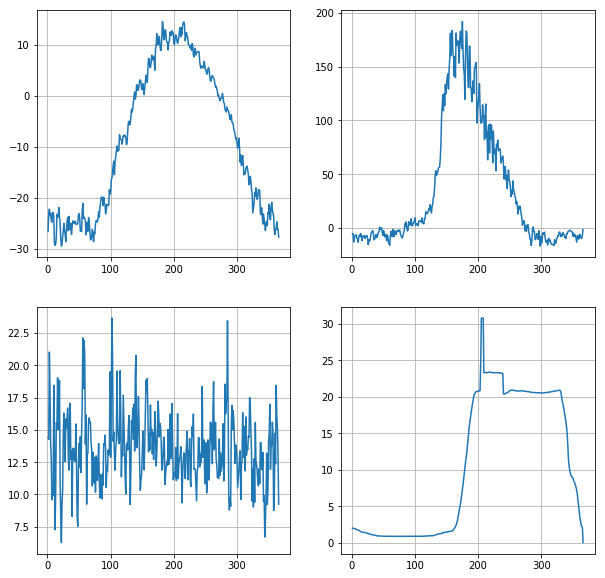

In [128]:
# Monthly = Data.ffill().resample('M').mean()


Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>.7] = np.nan
Daily['Snow_Depth'].ffill()

Data=Hourly.resample('D').mean()
Data=Data.groupby(Data.index.dayofyear).mean()
DailyData=Daily.groupby(Daily.index.dayofyear).mean()
# print(Monthly)

# print(Daily.head())

fig,ax = plt.subplots(2,2,figsize=(10,10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

ax1.plot(Data['AirTemp'])
ax1.grid()


ax2.plot(Data['Net_Ttl_Rad_Avg'])
ax2.grid()

ax3.plot(DailyData['WindSpd']*3.6)
# ax3.set_ylim(0,1)
ax3.grid()

ax4.plot(Data['SoilMoist(3)'])
ax4.grid()

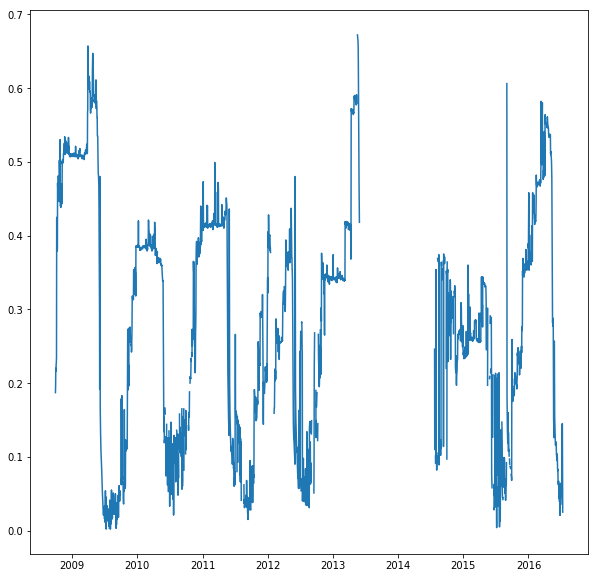

In [115]:
plt.figure(figsize=(10,10))
plt.plot(Daily['Snow_Depth'])